In [63]:
#%%
import os
import yaml
import torch
import argparse
import models
import numpy as np
from tqdm import tqdm
from collections import Counter
from datasets import MelDataset_lstm, MelDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# path
os.chdir('/mnt/work/')

# config path
# data_config_path = "./Animal/configs/monkey/dataset2.yaml"
# dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
# analy_set = MelDataset(dataset_config, used_key = ['twin_1_0'], subset='test') # 
# analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# config loading
data_config_path = "./Animal/configs/monkey/dataset4.yaml" # one class
# data_config_path = "./Animal/configs/monkey/dataset1.yaml" # all class 
model_config_path = "./Animal/configs/monkey/model_lstm.yaml"

# dataset
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = MelDataset_lstm(dataset_config, used_key = [[
                                                    #   'calltype_1',
                                                      'calltype_2',
                                                    #   'calltype_3',
                                                    #   'calltype_4',
                                                    #   'calltype_5',
                                                    #   'calltype_6',
                                                    #   'calltype_7',
                                                    #   'calltype_8',
                                                    #   'calltype_9',
                                                    #   'calltype_10'
                                                      ],
                                                                  [
                                                                   'twin_1_0',
                                                                   'twin_1_1',
                                                                  #  'twin_2_2',
                                                                #    'twin_2_3',
                                                                #    'twin_3_4',
                                                                #    'twin_3_5',
                                                                #    'twin_4_6',
                                                                #    'twin_4_7',
                                                                #    'twin_5_8',
                                                                #    'twin_5_9'
                                                                   ]], subset='test')


analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# device
# torch.cuda.set_device(0)
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(device = device, **model_config['DisentangledVAE1D']).to(device)# model config load

#load model
exp_name = 'DisentangledVAE1D-LSTM2'
model_path = 'Animal/output'
save_path = os.path.join(model_path, exp_name, 'checkpoint', "190000.pth.tar")
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_f_mean = []
total_f_logvar = []
total_z_post_mean = []
total_z_post_logvar = []
total_z_prior_mean = []
total_z_prior_logvar = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_ctID = []
total_cID = []

for mel, lenx, ctID, cID in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        
        outputs = model(mel) 
        
        f_mean = outputs['f_mean'].detach().cpu().numpy()
        f_logvar = outputs['f_logvar'].detach().cpu().numpy()
        
        z_post_mean = outputs['z_post_mean'].detach().cpu().numpy() 
        z_post_logvar = outputs['z_post_logvar'].detach().cpu().numpy() 
        z_prior_mean = outputs['z_prior_mean'].detach().cpu().numpy() 
        z_prior_logvar = outputs['z_prior_logvar'].detach().cpu().numpy() 
        
        x_rec = outputs['recon_x'].detach().cpu().numpy()

        total_f_mean.append(f_mean)
        total_f_logvar.append(f_logvar)
        total_z_post_mean.append(z_post_mean)
        total_z_post_logvar.append(z_post_logvar)
        total_z_prior_mean.append(z_prior_mean)
        total_z_prior_logvar.append(z_prior_logvar)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        total_ctID.append(ctID.detach().cpu().numpy())
        total_cID.append(cID.detach().cpu().numpy())

unique_elements, counts = np.unique(total_ctID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('ctID_counts',f"{element}: {count}")
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
for element, count in zip(unique_elements, counts):
    print('cID_counts',f"{element}: {count}")
    


Dict_1 ['calltype_2']
Dict_2 ['twin_1_0', 'twin_1_1', 'twin_2_2']


  0%|          | 0/4721 [00:00<?, ?it/s]

100%|██████████| 4721/4721 [01:33<00:00, 50.27it/s]

ctID_counts 2: 4721
cID_counts 0: 2159
cID_counts 1: 1041
cID_counts 2: 1521


In [64]:
print(total_f_mean[100].shape)

(1, 256)


In [65]:
print(total_z_prior_mean[100].mean(1).shape)

(1, 32)


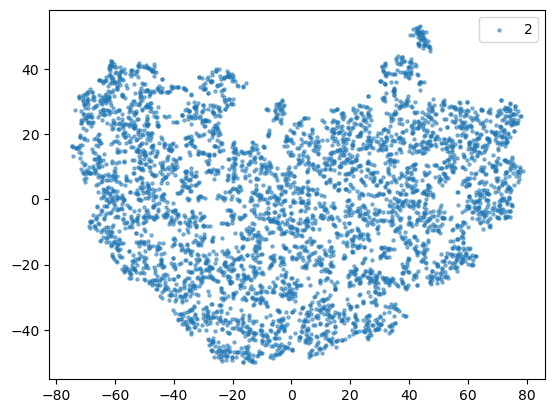

In [66]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_post_mean: # content: total_z_post_mean total_z_post_logvar
    total_z_con_1D.append(i.sum(1))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

data_2d = tsne.fit_transform(total_z_con_1D) # content

# Get unique labels
used_label = total_ctID
unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=5)

# Add a legend
plt.legend()
plt.show()

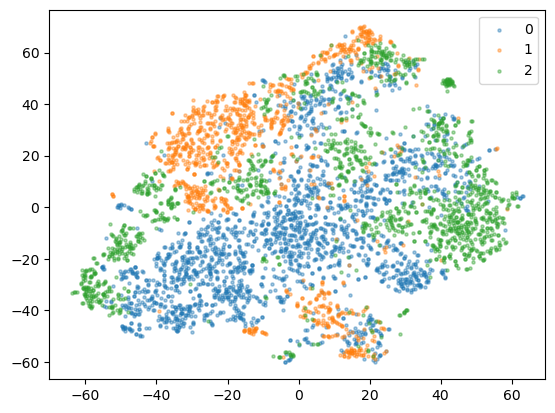

In [67]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_f_mean).squeeze() # indi total_f_mean total_f_logvar

# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d = tsne.fit_transform(total_z_indi)

# Get unique labels
used_label = total_cID

unique_labels = np.unique(used_label)

# Plot the transformed data with labels
for label in unique_labels:
    # Select data for this label
    data_for_label = data_2d[np.all(used_label == label, axis=1)]
    
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.4, s=5)

# Add a legend
plt.legend()
plt.show()

In [68]:
total_z_indi.shape
total_z_con_1D.shape

(4721, 32)